# Practical: MD and MC

## Monte Carlo

In [2]:
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 11.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


Simulating T = 1.50 K
T = 1.50 K, E = -7992.084 eV/spin, |M| = 0.986, C = 0.198
Simulating T = 1.60 K
T = 1.60 K, E = -7897.849 eV/spin, |M| = 0.980, C = 0.258
Simulating T = 1.70 K
T = 1.70 K, E = -7773.970 eV/spin, |M| = 0.970, C = 0.347
Simulating T = 1.80 K
T = 1.80 K, E = -7617.409 eV/spin, |M| = 0.942, C = 0.442
Simulating T = 1.90 K
T = 1.90 K, E = -7410.524 eV/spin, |M| = 0.938, C = 0.556
Simulating T = 2.00 K
T = 2.00 K, E = -7152.215 eV/spin, |M| = 0.912, C = 0.718
Simulating T = 2.10 K
T = 2.10 K, E = -6817.687 eV/spin, |M| = 0.700, C = 0.922
Simulating T = 2.20 K
T = 2.20 K, E = -6338.014 eV/spin, |M| = 0.709, C = 1.348
Simulating T = 2.30 K
T = 2.30 K, E = -5559.019 eV/spin, |M| = 0.483, C = 2.168
Simulating T = 2.40 K
T = 2.40 K, E = -4929.058 eV/spin, |M| = 0.142, C = 1.184
Simulating T = 2.50 K
T = 2.50 K, E = -4527.733 eV/spin, |M| = 0.116, C = 0.866
Simulating T = 2.60 K
T = 2.60 K, E = -4208.385 eV/spin, |M| = 0.080, C = 0.732
Simulating T = 2.70 K
T = 2.70 K, E = -3

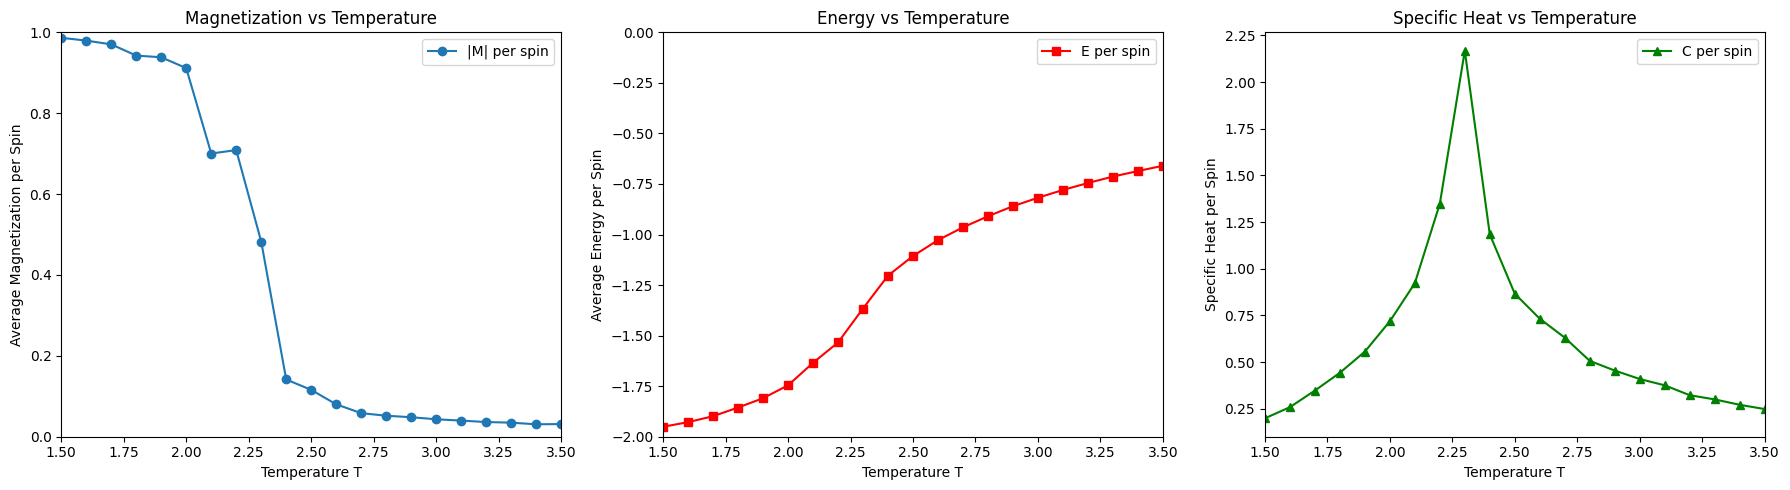

(array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
        2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 [0.98644365234375,
  0.979540478515625,
  0.9702671875,
  0.94246650390625,
  0.938353564453125,
  0.911546142578125,
  0.700337451171875,
  0.708797705078125,
  0.482557373046875,
  0.141636279296875,
  0.115818505859375,
  0.080205859375,
  0.058296337890625,
  0.051948876953125,
  0.0482072265625,
  0.043180322265625,
  0.039861376953125,
  0.0363427734375,
  0.03476875,
  0.03074345703125,
  0.031267431640625],
 [-1.9508822265625,
  -1.92791875,
  -1.89853173828125,
  -1.85561796875,
  -1.8096216796875,
  -1.74581767578125,
  -1.63452236328125,
  -1.5339140625,
  -1.36590595703125,
  -1.203241796875,
  -1.10629013671875,
  -1.0276837890625,
  -0.9644478515625,
  -0.9096236328125,
  -0.859937890625,
  -0.81811650390625,
  -0.7796388671875,
  -0.745257421875,
  -0.71339111328125,
  -0.6859888671875,
  -0.65999013671875],
 [0.19828691526021833,
  0.25800197015399

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def initial_state(N):
    """
    Generate an N x N lattice with spins ±1.
    For better compatibility with Numba, using explicit array creation
    instead of relying on random.randint with subtraction.
    """
    config = np.empty((N, N), dtype=np.int64)
    for i in range(N):
        for j in range(N):
            # Randomly assign -1 or 1
            config[i, j] = 1 if np.random.random() < 0.5 else -1
    return config

def create_neighbor_list(N):
    """
    Create a neighbor list for each spin in the lattice.
    """
    neighbor_list = {}
    for i in range(N):
        for j in range(N):
            neighbors = [
                ((i+1) % N, j),
                ((i-1) % N, j),
                (i, (j+1) % N),
                (i, (j-1) % N)
            ]
            neighbor_list[(i, j)] = neighbors
    return neighbor_list

@njit
def mc_step(config, beta):
    """
    Perform one Monte Carlo sweep using the Metropolis algorithm.
    One sweep means N*N spin update attempts.
    
    Parameters:
      config: 2D numpy array of spins
      beta: 1/T (temperature inverse in natural units, with J=kB=1)
      neighbor_list: Dictionary of neighbors for each site (ignored in this implementation)
    Returns:
      Updated spin configuration.
    """
    N = config.shape[0]
    for _ in range(N*N):
        # Generate random coordinates for spin flip attempt
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        s = config[i, j]
        
        # Calculate energy difference directly from neighbors
        nb_sum = 0
        nb_sum += config[(i+1) % N, j]
        nb_sum += config[(i-1) % N, j]
        nb_sum += config[i, (j+1) % N]
        nb_sum += config[i, (j-1) % N]
        
        # Energy change if we flip this spin
        dE = 2 * s * nb_sum
        
        # Metropolis acceptance criterion
        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            config[i, j] = -s
    
    return config

@njit
def calc_energy(config, J=1):
    """
    Calculate the total energy of the configuration.
    
    Hamiltonian: H = -J Σ_{<ij>} s_i s_j with J=1.
    Each neighbor pair is counted twice so we divide by 2.
    """
    N = config.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            S = config[i, j]
            # Calculate contribution from neighbors directly
            nb_sum = config[(i+1) % N, j] + config[(i-1) % N, j] + config[i, (j+1) % N] + config[i, (j-1) % N]
            energy += -S * J * nb_sum
    return energy / 2.0

@njit
def calc_magnetization(config):
    """
    Calculate the magnetization of the configuration.
    
    Magnetization: M = Σ s_i
    """
    return np.sum(config)

@njit
def run_simulation(N, T, n_equil, n_steps):
    """
    Run a simulation at a specific temperature and return results
    """
    beta = 1.0 / T
    config = initial_state(N)
    
    # Equilibration
    for _ in range(n_equil):
        config = mc_step(config, beta)
    
    # Measurement
    E_total = 0.0
    M_total = 0.0
    configs = np.zeros((n_steps//100 + 1, N, N), dtype=np.int64)
    configs[0] = config.copy()
    
    save_idx = 1
    for step in range(n_steps):
        config = mc_step(config, beta)
        E_total += calc_energy(config)
        M_total += abs(calc_magnetization(config))
        
        if step % 100 == 0 and save_idx < len(configs):
            configs[save_idx] = config.copy()
            save_idx += 1
            
    E_avg = E_total / (n_steps * N * N)
    M_avg = M_total / (n_steps * N * N)
    
    return E_avg, M_avg, configs

# Function to create animation
def create_ising_animation(N=64, T=2.27, n_equil=1000, n_steps=10000):
    import plotly.graph_objects as go
    
    _, _, configs = run_simulation(N, T, n_equil, n_steps)
    
    # Create initial figure
    fig = go.Figure(
        data=go.Heatmap(
            z=configs[0],
            colorscale='RdBu',  # Red-Blue colorscale similar to coolwarm
            showscale=True,
            colorbar=dict(title='Spin'),
            zmin=-1, zmax=1
        ),
        layout=go.Layout(
            title=f'Ising Model at T = {T:.2f}, Frame 0',
            width=700, height=700,
            updatemenus=[{
                'type': 'buttons',
                'buttons': [{
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
                }, {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]
                }],
                'direction': 'left',
                'pad': {'r': 10, 't': 10},
                'showactive': False,
                'x': 0.1,
                'y': 0,
                'xanchor': 'right',
                'yanchor': 'top'
            }],
            sliders=[{
                'active': 0,
                'yanchor': 'top',
                'xanchor': 'left',
                'currentvalue': {
                    'visible': True,
                    'prefix': 'Frame: ',
                    'xanchor': 'right'
                },
                'transition': {'duration': 100},
                'pad': {'b': 10, 't': 50},
                'len': 0.9,
                'x': 0.1,
                'y': 0,
                'steps': [{
                    'method': 'animate',
                    'label': str(i),
                    'args': [[str(i)], {
                        'frame': {'duration': 100, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                } for i in range(len(configs))]
            }]
        ),
        frames=[go.Frame(
                data=[go.Heatmap(z=configs[i])],
                name=str(i),
                layout=go.Layout(title_text=f'Ising Model at T = {T:.2f}, Frame {i}')
            ) for i in range(len(configs))
        ]
    )
    
    return fig

# Function to run full simulation with temperature sweep
def run_ising_simulation(N=64, temps=None, n_equil=1000, n_steps=10000):
    if temps is None:
        temps = np.linspace(1.5, 3.5, 21)
    
    magnetizations = []
    energies = []
    specific_heats = []
    
    for T in temps:
        print(f"Simulating T = {T:.2f} K")
        E_avg, M_avg, configs = run_simulation(N, T, n_equil, n_steps)
        energies.append(E_avg)
        magnetizations.append(M_avg)
        
        # Calculate energy fluctuations for specific heat
        # Need to run an additional loop to collect E^2 samples
        beta = 1.0 / T
        config = configs[-1].copy()  # Use the last config as starting point
        E_total = 0.0
        E_squared_total = 0.0
        
        for _ in range(n_steps):
            config = mc_step(config, beta)
            E = calc_energy(config)
            E_total += E
            E_squared_total += E**2
            
        E_avg = E_total / n_steps
        E_squared_avg = E_squared_total / n_steps
        # Specific heat: C = (β^2 / N^2) * (<E^2> - <E>^2)
        C = (beta**2) * (E_squared_avg - E_avg**2) / (N**2)
        specific_heats.append(C)
        
        print(f"T = {T:.2f} K, E = {E_avg:.3f} eV/spin, |M| = {M_avg:.3f}, C = {C:.3f}")
        
    # Create plot with 3 panels
    fig, (ax_mag, ax_eng, ax_heat) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax_mag.plot(temps, magnetizations, 'o-', label='|M| per spin')
    ax_mag.set_xlabel('Temperature T')
    ax_mag.set_ylabel('Average Magnetization per Spin')
    ax_mag.set_title('Magnetization vs Temperature')
    ax_mag.set_xlim(temps[0], temps[-1])
    ax_mag.set_ylim(0, 1.0)
    ax_mag.legend()
    
    ax_eng.plot(temps, energies, 's-', color='red', label='E per spin')
    ax_eng.set_xlabel('Temperature T')
    ax_eng.set_ylabel('Average Energy per Spin')
    ax_eng.set_title('Energy vs Temperature')
    ax_eng.set_xlim(temps[0], temps[-1])
    ax_eng.set_ylim(-2.0, 0)
    ax_eng.legend()
    
    ax_heat.plot(temps, specific_heats, '^-', color='green', label='C per spin')
    ax_heat.set_xlabel('Temperature T')
    ax_heat.set_ylabel('Specific Heat per Spin')
    ax_heat.set_title('Specific Heat vs Temperature')
    ax_heat.set_xlim(temps[0], temps[-1])
    ax_heat.legend()
    
    fig.tight_layout()
    plt.show()
    
    return temps, magnetizations, energies, specific_heats
# Example usage
# Display animation for temperature near critical point
fig = create_ising_animation(N=32, T=2.1)
fig.show()
# For full simulation with temperature sweep
run_ising_simulation()
